# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-3.358153,False,-9.350810
1,0.493891,True,5.706644
2,-1.192573,True,1.018373
3,-1.157688,False,-3.657911
4,-0.151085,True,4.307722
...,...,...,...
995,-1.117842,False,-3.427411
996,-0.726809,False,-2.760992
997,-0.153110,True,3.359161
998,0.682208,True,6.135730


<AxesSubplot: xlabel='v0'>

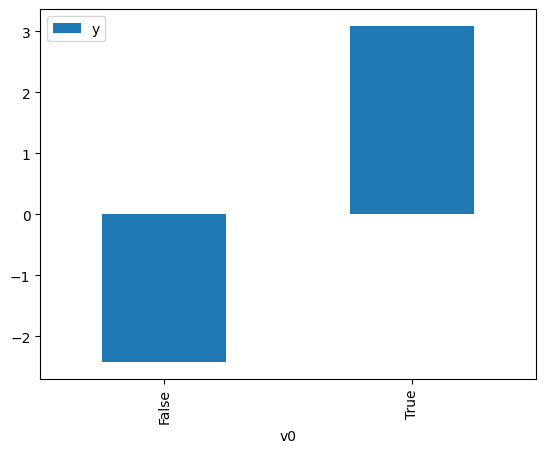

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

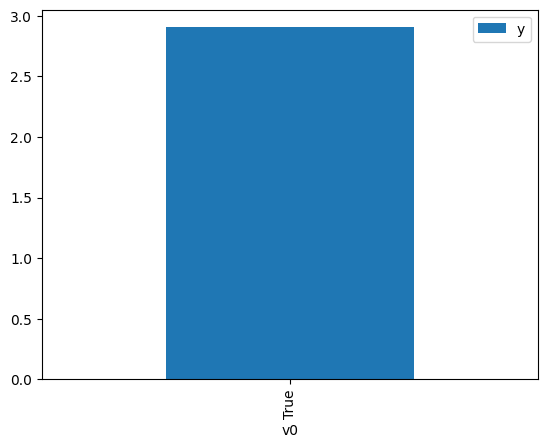

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.487008,False,-1.323455,0.686314,1.457060
1,0.415041,False,0.454410,0.408321,2.449051
2,-1.619407,False,-3.009626,0.903038,1.107374
3,0.101335,False,-1.071200,0.507591,1.970091
4,-2.710337,False,-5.441053,0.974091,1.026599
...,...,...,...,...,...
995,-0.077835,False,-0.864763,0.564526,1.771399
996,-2.207699,False,-6.338976,0.951844,1.050593
997,-2.832575,False,-7.211358,0.977757,1.022748
998,-1.994873,False,-4.981812,0.937714,1.066423


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.269722,True,5.220693,0.546125,1.831083
1,1.269864,True,7.335224,0.812197,1.231228
2,-1.578454,True,0.724388,0.101647,9.837956
3,0.422021,True,7.166095,0.593834,1.683972
4,-2.354405,True,-0.645385,0.040248,24.845804
...,...,...,...,...,...
995,-0.885870,True,3.052518,0.215322,4.644217
996,-1.421507,True,0.980520,0.121500,8.230424
997,-1.484017,True,1.381338,0.113221,8.832308
998,-1.484017,True,1.381338,0.113221,8.832308


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              9725.
Date:                Sat, 27 May 2023   Prob (F-statistic):                        0.00
Time:                        02:16:29   Log-Likelihood:                         -1371.1
No. Observations:                1000   AIC:                                      2746.
Df Residuals:                     998   BIC:                                      2756.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5969      0.022    117.367      0.000       2.554       2.640
x2             5.0586      0.060     84.384      0.000       4.941       5.176
==============================================================================
Omnibus:                        1.158   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.560   Jarque-Bera (JB):                1.094
Skew:                           0.080   Prob(JB):                        0.579
Kurtosis:                       3.027   Cond. No.                         2.72
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""